# RC4558 运放

**内部电路分析与仿真**

陈硕 2024/06 初稿

根据 https://www.learningelectronics.net/VA3AVR/gadgets/741/741.html 的说法，RC4558 是 Raytheon 公司 1974 首次年推出的双运放，跟至今流行的 LM324 四运放同年上市。RC4558 性能与 741 相仿，前者在带宽方面略好，较适合音频应用。日本的 JRC 公司在 1980s 仿制成功 JRC4558 (现 NJM4558)，因其廉价，在 90 年代的中低档组合音响中用得很多（高档音响一般用 NE5532）。

>  Raytheon 公司于 2020 年关张。它在 1950s 销售的 [CK722](https://en.wikipedia.org/wiki/CK722) PNP 锗管是第一款低价三极管，当年在电子爱好者中很受欢迎，可以说为普及晶体管电路做了贡献。

TI 目前还在生产 RC4558，可能是因收购 National 而继承的产品线，其[技术手册](https://www.ti.com/lit/ds/symlink/rc4558.pdf)如实反应了当输入共模电压过低时会出现的相位反转 (phase reversal)现象，我们后面的仿真结果与此相符。

ElectroSmash 网站上有对 JRC4558 工作原理的详细（定性）介绍： https://www.electrosmash.com/jrc4558-analysis

从内部电路上看，[TL072](https://leachlegacy.ece.gatech.edu/ece4435/sp08/TL071ckt.pdf) 和 RC4558 可以说如出一辙，只是把输入的 PNP 差分管换成了 JFET。

![](/741/rc4558.png)

借助分析 RC4558 内部电路，可以将模拟电路的很多知识串到一起复习，大致步骤如下：

* 分析直流工作点，计算各支路的电流
* 计算交流小信号增益，计算各级的阻抗与跨导
* 分析频率相应与 slew-rate


In [1]:
%matplotlib inline
%load_ext tikzmagic

from math import exp, log, log10
import numpy as np
from matplotlib import pyplot as plt
import scipy

def para(r1, r2):
  return (r1*r2) / (r1 + r2)

## 内部电路概述 schematic

以下是根据原厂 [1994 年的数据手册](/img/rc4558-1994.pdf)重绘的内部电路。

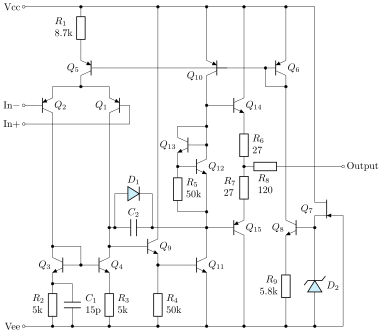

In [3]:
# DO NOT REMOVE

这个电路有 15 个晶体管，比 741 的略微简单一些，是典型的三级运放（差分输入级、中间增益级、输出缓冲级）。

> 有的英文文献把这种典型结构算成两级放大：差分输入级、共射增益级。输出级是电流缓冲，没有电压放大的功能，因此不算在内。

* Q5/Q6/Q7/Q8/Q10 是电流源，为各级提供偏置电流
* Q1/Q2/Q3/Q4 是有源负载差分输入级
* Q9/Q11 是中间增益级，其中 Q9 是射极跟随器，Q11/Q10 是高增益的有源负载共射放大器
* Q14/Q15 是推挽输出级，Q12/Q13 用于消除交越失真

注意这个电路中没有主动的限流电路，短路保护是通过电阻实现的。

以下是简化的信号通路(signal path)，与 [741 非常类似](https://chenshuo.com/notes/XL741/#full-and-simplified-schematic)。

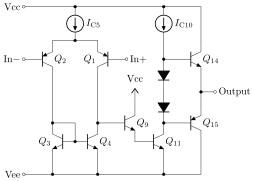

In [4]:
# DO NOT REMOVE

## DC 工作点计算与仿真

原理图上只给了电阻的阻值，没有其他器件参数。我们按一般双极型集成电路的器件参数来建模，但是晶体管的面积之比就无从得知了。
参数取自 Paul & Meyer, _Analysis and Design of Analog Integrated Circuits_, 5e.
$\newcommand{\li}[1]{{i_\mathrm{#1}}}$
$\newcommand{\ui}[1]{{I_\mathrm{#1}}}$
$\newcommand{\lv}[1]{{v_\mathrm{#1}}}$
$\newcommand{\uv}[1]{{V_\mathrm{#1}}}$
$\newcommand{\sm}[2]{{{#1}_\mathrm{#2}}}$

| 参数 | NPN | 横向 PNP |
| --- | --- | --- |
| $\ui{S}$ | $\ui{SN}=5\mathrm{fA}$ | $\ui{SP}=2\mathrm{fA}$ |
| $\beta$ | $\sm{\beta}{N}=200$ | $\sm{\beta}{P}=50$ |
| $\uv{A}$ | $\uv{AN}= 130$V | $\uv{AP}=50$V |

* 集成电路中的 PNP 管有纵向 (vertical)、横向 (lateral)、衬底 (substrate) 等种类，这里统一按 lateral PNP 的参数来计算。


### 偏置电路

RC4558 的偏置电路比 741 简单：

* JFET Q7 给 Zener 二极管 D2 提供一个基本稳定的工作电流，D2 给 Q8 的基极提供参考电压
* Q8/R9/D2 产生基本不随电源电压变化的参考电流 $\ui{ref}=\ui{C8}\approx\dfrac{\uv{D2}-\uv{EE}-\uv{BE8}}{R_9}$
* Q6/Q10 是基本的镜像电流源，为 Q11 提供偏置电流。我们假定 $\ui{C10} = \ui{C8}$
* Q5/Q6 是 Widlar 微电流源，为差分输入级提供偏置电流 $\ui{C5}$

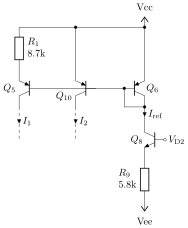

In [13]:
# DO NOT REMOVE

**温度补偿**

$\sm{g}{m} = \dfrac{\ui{C}}{\uv{T}}$，而 $\uv{T}$ 与绝对温度 $T$ 成正比，因此如果 $\ui{C}$ 恒定，那么温度越高 $\sm{g}{m}$ 越小，这不利于电路的稳定工作。
例如 $r_\pi=\dfrac{\beta}{\sm{g}{m}}$，而 $\beta$ 随温度升高也会增大，因此随温度升高 $r_\pi$ 会增加，相应的 $I_\mathrm{bias}$ 会减小。

解决办法是设法让 $\ui{C}$ 也随温度增加而增大，这样就能让 $\sm{g}{m}$ 基本不变，从而使得电路参数稳定。RC4558 的偏置电路有一定的温度补偿效果（据我观察）： $\uv{BE8}$ 有负温度系数，而 $D_2$ 通常是正温度系数，二者叠加（不是抵消），使得 R9 两端的电压有正温度系数，从而让主参考电流 $\ui{C8}$ 也有正温度系数，借此保持 $\sm{g}{m}$ 大体稳定。

$\uv{BE}-\ui{C}$ 关系，便于估算工作点 

| 参数 | NPN | 横向 PNP |
| --- | --- | --- |
| $\ui{S}$ | 5fA | 2fA |
| $\uv{BE}=0.60$V | 52.6uA | 21.0uA |
| $\uv{BE}=0.65$V | 0.360mA | 0.144mA |
| $\uv{BE}=0.7$V | 2.46mA | 0.985mA |

### 偏置电流 bias currents

以下估算以 $\beta \gg 1$ 为前提，因此忽略基极电流，认为 $\ui{E}\approx\ui{C}$

Zener 二极管 D2 的稳定电压未知，不妨假设是 5.6V，那么 Q8 e 极对 Vee 的电压约为 $5.6-0.6=5$V，$\ui{ref}\approx 5/5.8 \approx 0.86$mA.
因此 $I_2 = \ui{C10}\approx\ui{C11}\approx 0.86$mA.

接下来考虑 Q5/R1 的微电流源

$\ui{C5}R_1 = \uv{T}\ln\dfrac{\ui{ref}}{\ui{C5}}$

In [16]:
def Ic5(x):
    Ic = x
    Vt = 26
    Iref = 860
    R4 = 8.7
    return Ic * R4 - Vt * np.log(Iref / Ic)

root = scipy.optimize.root_scalar(Ic5, x0=0.1)
if root.converged:
    Ic = root.root
    print('Ic5 = %.2f uA' % (Ic))

Ic5 = 12.62 uA


故 $\ui{C1}=\ui{C2}=\ui{C3}=\ui{C4}=\dfrac{\ui{C5}}{2} = 6.31$uA.

中间级的工作点，由 $\ui{C11}=I_2\approx 0.86$mA 可知：

$\uv{BE11} = \uv{T}\ln\dfrac{\ui{C11}}{\ui{SN}} = 26\ln\dfrac{0.86\mathrm{mA}}{5\mathrm{fA}}\approx 0.673$V

$\ui{E9}=\ui{R4}+\ui{B11} = \dfrac{\uv{BE11}}{R_4} + \dfrac{\ui{C11}}{\beta_\mathrm{N}} = \dfrac{0.673}{50} + \dfrac{0.86}{200} \approx 0.0178$mA.

$\uv{BE9} = \uv{T}\ln\dfrac{\ui{C9}}{\ui{SN}}=26\ln\dfrac{17.8\mathrm{uA}}{5\mathrm{fA}}\approx 0.572$V


最后，计算输出级。

先估算 Q12/Q13 电流。

* $\ui{E12} + \ui{R5}=I_2=0.86$mA

* 假定大部分电流从 Q12 流过，即 $\ui{E12}\gg\ui{R5}$，则 $\ui{C12}\approx I_2$
* $\uv{BE12}=\uv{T}\ln\dfrac{\ui{C12}}{\ui{SN}}\approx  26\ln\dfrac{0.86\mathrm{mA}}{5\mathrm{fA}}\approx 0.673$V
* $\ui{E13}=\ui{R5}+\ui{B12} = \dfrac{\uv{BE12}}{R_5} + \dfrac{\ui{C12}}{\beta_\mathrm{N}} = \dfrac{0.673}{50} + \dfrac{0.86}{200} \approx 0.0178$mA. 可见确实符合前面的电流分配假设。


最后计算 Q14/Q15，先忽略 R6 和 R7 上的电压，我们就得到了一个 translinear 电路。
假设输出管的面积是普通管子的 3 倍，仿照 [741 的计算方法](/741/#24t)。

* $\ui{E12}\ui{E13}=\dfrac{1}{3^2}\ui{E14}\ui{E15}$
* $\ui{E14}=\ui{E15}=3\sqrt{\ui{E12}\ui{E13}}=3\sqrt{860\times 17.8}=371$uA

至此，各支路的电流已求出。

| 三极管 | 手算 | 仿真 |
| --- | --- | --- |
| Q1/Q2/Q3/Q4 | 6.31uA | |
| Q5 | 12.62uA | |
| Q8/Q6/Q10/Q11 | 860uA | |
| Q9 | 17.8uA | | 
| Q12| 860uA | |
| Q13 | 17.8uA | | 
| Q14/Q15 | 371uA | |

在计算过程中我们没有用到电源电压，也暂时忽略了 Early 效应的影响。
换句话说，RC4558 的直流工作点与电源电压基本无关，这也是它能宽电压工作的主要原因。

> 741 的主参考电流是靠 39kΩ 的 R5 来提供，大致跟电源电压成正比。


## AC 小信号增益

我们先一级一级计算：

* 输入阻抗
* 输出阻抗
* 电压增益

最后把结果汇总就得到了整个电路的开环增益。

### 差分输入级 differential pair

三极管的 hybrid-pi 小信号模型：

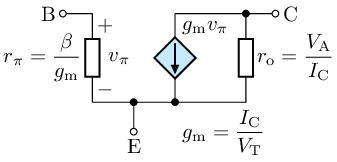

In [10]:
%%tikz -ct
\ctikzset{european resistors, american voltages}
\ctikzset{transistors/arrow pos=end, transistors/fill=cyan!20}
\ctikzset{diodes/fill=cyan!20, csources/fill=cyan!20}
\newcommand{\sm}[2]{\ensuremath{{#1}_\mathrm{#2}}}
    
\draw (0,0) to [R, l_={$r_\pi=\displaystyle\frac{\beta}{\sm{g}{m}}$}, v^>={$v_\pi$}, bipoles/length=0.8cm] ++(0, -1.5) coordinate (E);
\draw (0,0) to [short, -o] ++(-0.5, 0) node [left] {B};
%\draw [dashed] (Q.E) to [short] (Q.E |- E);
\draw (E) ++(0.7, 0) to [short, *-o] ++(0, -0.5) node [below] {E};
\draw (1.4, 0) coordinate (C)
  node [below right] {$\sm{g}{m}v_\pi$}
  to [american controlled current source, bipoles/length=1cm] (C|-E) node [circ] {}
  node [below right] {$\sm{g}{m}=\displaystyle\frac{\sm{I}{C}}{\sm{V}{T}}$};
\draw (C) to [short] ++(1.2, 0) coordinate (D)
  to [R, l={$\sm{r}{o}=\displaystyle\frac{\sm{V}{A}}{\sm{I}{C}}$}, bipoles/length=0.8cm] (D|-E)-- (E);
\draw (D) to [short, *-o] ++(0.5, 0) node [right] {C};

* 跨导 $\sm{g}{m}=\dfrac{\ui{C}}{\uv{T}}=\dfrac{6.31\mathrm{uA}}{26\mathrm{mV}}$
* Q1 单管输入电阻 $r_{\pi1}=\dfrac{\sm{\beta}{P}}{\sm{g}{m}}=\dfrac{50\times 26}{6.31} = 206$kΩ
* $r_\pi$ 在国内教材上一般叫 $\sm{r}{be}$ 或 $\sm{r}{b'e}$
* $v_\pi$ 在国内教材上一般叫 $\sm{v}{be}$ 或 $\sm{v}{b'e}$
* $\sm{r}{o}$ 在国内教材上一般叫 $\sm{r}{ce}$

**差分输入电阻** $\sm{R}{id}=2r_{\pi1}=2\times 206=412$kΩ，手册上给的典型数据是 1MΩ

我认为手册上给的数据有一点小小的不一致：

* 输入电阻 1MΩ
* 输入偏置电流 40nA，即 $\ui{B}=40$nA


按照 hybrid-pi 模型

* $r_\pi=\dfrac{\uv{T}}{\ui{B}}=\dfrac{26\mathrm{mV}}{40\mathrm{nA}}=650$kΩ
* 那么输入电阻应该是 1.3MΩ

**输出电阻** $\sm{R}{o1}=\sm{r}{o1}/\!/\sm{R}{o4}$

$\sm{r}{o1} = \dfrac{\uv{AP}}{\ui{C1}} = \dfrac{50V}{6.31\mathrm{uA}}\approx 7.924$MΩ

电流源负载的输出电阻 $\sm{R}{o4} = \sm{r}{o4}[1+\sm{g}{m}(R_3/\!/ r_{\pi4})]$

* $\sm{r}{o4}=\dfrac{\uv{AN}}{\ui{C1}} = \dfrac{130V}{6.31\mathrm{uA}}\approx 20.6$MΩ

* $ r_{\pi4}=\dfrac{\sm{\beta}{N}}{\sm{g}{m}}=\dfrac{200\times 26\mathrm{mV}}{6.31\mathrm{uA}}=824$kΩ
* 因 $R_3\ll r_{\pi4}$，$R_3/\!/ r_{\pi4}\approx R_3=5$kΩ
* $\sm{R}{o4} = \sm{r}{o4}(1+\sm{g}{m}R_3)=\sm{r}{o4}(1+\dfrac{5000\times 6.31\mathrm{uA}}{\uv{T}})=2.213 \sm{r}{o4}=45.6$MΩ

### 增益级 common-emitter

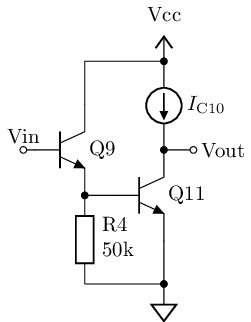

In [11]:
# DO NOT REMOVE

先求出本级的输入电阻 $\sm{R}{i2}$，这也是第一级的负载电阻。因此，第一级的电压增益
$\sm{A}{v1}=\sm{g}{m1}(\sm{R}{o1} /\!/ \sm{R}{i2})$

Q9 是射极跟随器，其负载电阻为 $R_4 /\!/ r_{\pi11}$

* $r_{\pi9}=\dfrac{\sm{\beta}{N}\uv{T}}{\ui{C9}}=\dfrac{200\times 26\mathrm{mV}}{17.8\mathrm{uA}}=292$kΩ
* $r_{\pi11}=\dfrac{\uv{T}}{\ui{B11}}=\dfrac{26\mathrm{mV}}{0.86\mathrm{mA}/200}=6046.5$Ω
* $\sm{R}{i2}=r_{\pi9}+(1+\sm{\beta}{N})(R_4 /\!/ r_{\pi11})$
* $\sm{R}{i2}=292 + 201\times 5.3942=1376$kΩ


* $\sm{R}{o1} /\!/ \sm{R}{i2} = \sm{r}{o1} /\!/ \sm{R}{o4} /\!/ \sm{R}{i2} = (7.924 /\!/ 45.6 /\!/ 1.376)=1.143$MΩ

由此可算出第一级的电压增益 $\sm{A}{v1}$ 

$\sm{A}{v1}=\sm{g}{m1}(\sm{R}{o1} /\!/ \sm{R}{i2}) = \dfrac{6.31\mathrm{uA}}{26\mathrm{mV}}\times 1.143$MΩ = 277

第二级电压增益主要由 Q11 及其有源负载 Q10 提供。
前面算出其偏置电流为 $\ui{C10}=\ui{C11}=0.86$mA，因此第二级的输出电阻

$\sm{R}{o2}=(\sm{r}{o11}/\!/\sm{r}{o10})= \dfrac{\uv{AP}}{\ui{C10}}/\!/\dfrac{\uv{AN}}{\ui{C11}}\approx 42$kΩ

输出级为射极跟随器，不妨认为其输入阻抗 $\sm{R}{i3}\gg \sm{R}{o2}$，从而粗略估算本级的电压增益 $\sm{A}{v2}$ 为

$\sm{A}{v2}=\sm{g}{m11}(\sm{r}{o11}/\!/\sm{r}{o10})=\dfrac{\uv{AN}\uv{AP}}{\uv{T}(\uv{AN}+\uv{AP})} = \dfrac{130\times 50}{26\times(130+50)}\times 1000=1389$

可见整个电路的增益主要由第二级提供。总的增益为 $\sm{A}{v1}\sm{A}{v2}=277\times 1389=384,753$，合 111.7dB

## 频率响应与压摆率

待续。。。